# Stable Diffusion with 🤗 Diffusers

**Pedro Cuenca, Patrick von Platen, Suraj Patil, Jeremy Howard**

Chances are you'll have seen examples in Twitter (and elsewhere) of images generated by typing a short description of the scene you want to create. This is the culmination of years of work in generative models. This notebook introduces Stable Diffusion, the highest-quality open source text to image model as of now. It's also small enough to run in consumer GPUs rather than in a datacenter. We use the 🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers), which is currently our recommended library for using diffusion models.

As we'll see during the course, understanding state-of-the-art generative models requires a deep understanding of many of the fundamental blocks in modern machine learning models. This notebook shows what Stable Diffusion can do and a glimpse of its main components.

_If you open this notebook in Colab, or if you get type errors when generating your first image, please uncomment and run the following cell._

In [1]:
!pip install -Uq diffusers transformers fastcore

     |████████████████████████████████| 524 kB 7.3 MB/s 
     |████████████████████████████████| 5.8 MB 72.3 MB/s 
     |████████████████████████████████| 182 kB 76.2 MB/s 
     |████████████████████████████████| 7.6 MB 58.3 MB/s 


## Using Stable Diffusion

To run Stable Diffusion on your computer you have to accept the model license. It's an open CreativeML OpenRail-M license that claims no rights on the outputs you generate and prohibits you from deliberately producing illegal or harmful content. The [model card](https://huggingface.co/CompVis/stable-diffusion-v1-4) provides more details. If you do accept the license, you need to be a registered user in 🤗 Hugging Face Hub and use an access token for the code to work. You have two options to provide your access token:

* Use the `huggingface-cli login` command-line tool in your terminal and paste your token when prompted. It will be saved in a file in your computer.
* Or use `notebook_login()` in a notebook, which does the same thing.

In [2]:
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from diffusers import StableDiffusionPipeline
from fastcore.all import concat
from huggingface_hub import notebook_login
from PIL import Image

logging.disable(logging.WARNING)

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


### Stable Diffusion Pipeline

[`StableDiffusionPipeline`](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion#diffusers.StableDiffusionPipeline) is an end-to-end [diffusion inference pipeline](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion) that allows you to start generating images with just a few lines of code. Many Hugging Face libraries (along with other libraries such as scikit-learn) use the concept of a "pipeline" to indicate a sequence of steps that when combined complete some task. We'll look at the individual steps of the pipeline later -- for now though, let's just use it to see what it can do.

When we say "inference" we're referring to using an existing model to generate samples (in this case, images), as opposed to "training" (or fine-tuning) models using new data.

We use [`from_pretrained`](https://huggingface.co/docs/diffusers/main/en/api/diffusion_pipeline#diffusers.DiffusionPipeline.from_pretrained) to create the pipeline and download the pretrained weights. We indicate that we want to use the `fp16` (half-precision) version of the weights, and we tell `diffusers` to expect the weights in that format. This allows us to perform much faster inference with almost no discernible difference in quality. The string passed to `from_pretrained` in this case (`CompVis/stable-diffusion-v1-4`) is the repo id of a pretrained pipeline hosted on [Hugging Face Hub](https://huggingface.co/models); it can also be a path to a directory containing pipeline weights. The weights for all the models in the pipeline will be downloaded and cached the first time you run this cell.

In [3]:
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16).to("cuda")

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/307 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/788 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

The weights are cached in your home directory by default.

In [4]:
!ls ~/.cache/huggingface/diffusers/

models--CompVis--stable-diffusion-v1-4


We are now ready to use the pipeline to start creating images.

If your GPU is not big enough to use `pipe`, run `pipe.enable_attention_slicing()`  
As described in the docs:  
> When this option is enabled, the attention module will split the input tensor in slices, to compute attention in several steps. This is useful to save some memory in exchange for a small speed decrease.

In [5]:
pipe.enable_attention_slicing()

In [16]:
prompt = "Barcelona flooded 3 meters by sea level rise"

  0%|          | 0/50 [00:00<?, ?it/s]

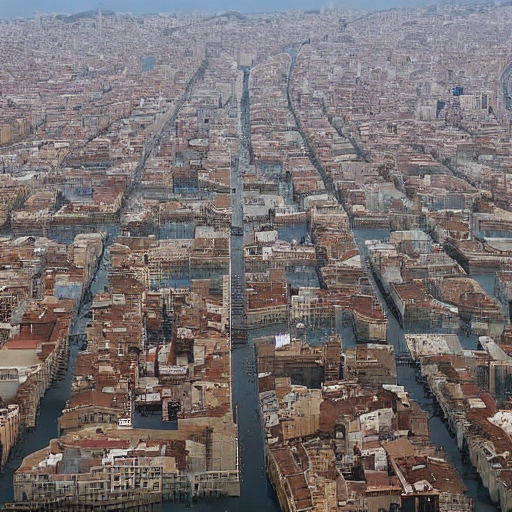

In [17]:
pipe(prompt).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

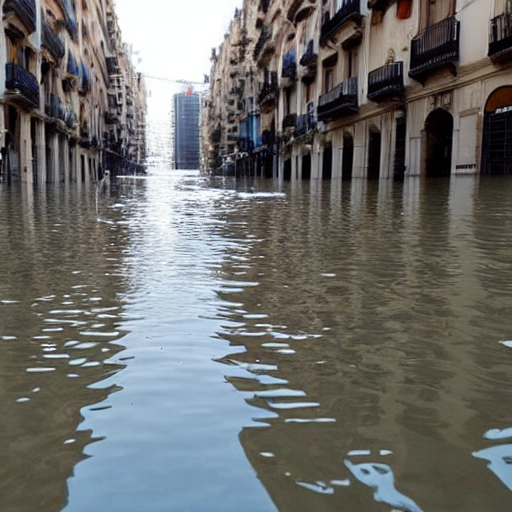

In [18]:
torch.manual_seed(1024)
pipe(prompt).images[0]

You will have noticed that running the pipeline shows a progress bar with a certain number of steps. This is because Stable Diffusion is based on a progressive denoising algorithm that is able to create a convincing image starting from pure random noise. Models in this family are known as _diffusion models_. Here's an example of the process (from random noise at top to progressively improved images towards the bottom) of a model drawing handwritten digits, which we'll build from scratch ourselves later in the course.

![image.png](attachment:image.png)

  0%|          | 0/3 [00:00<?, ?it/s]

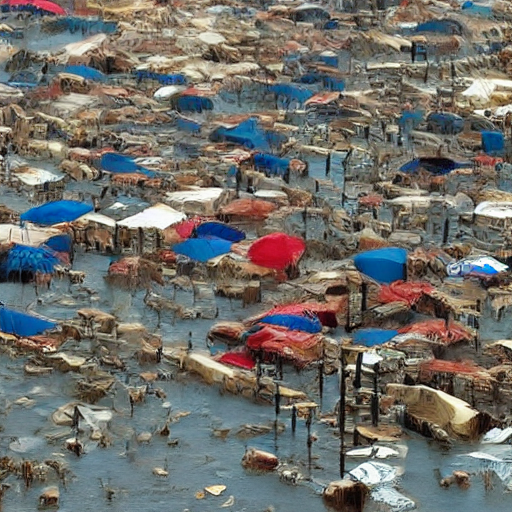

In [19]:
torch.manual_seed(1024)
pipe(prompt, num_inference_steps=3).images[0]

  0%|          | 0/16 [00:00<?, ?it/s]

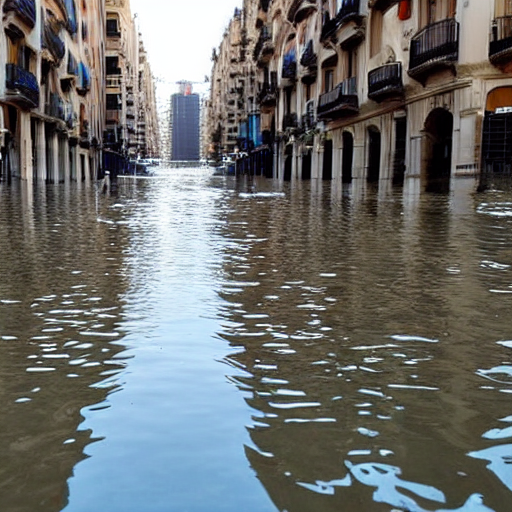

In [20]:
torch.manual_seed(1024)
pipe(prompt, num_inference_steps=16).images[0]

### Classifier-Free Guidance

In [21]:
def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

_Classifier-Free Guidance_ is a method to increase the adherence of the output to the conditioning signal we used (the text).

Roughly speaking, the larger the guidance the more the model tries to represent the text prompt. However, large values tend to produce less diversity. The default is `7.5`, which represents a good compromise between variety and fidelity. This [blog post](https://benanne.github.io/2022/05/26/guidance.html) goes into deeper details on how it works.

We can generate multiple images for the same prompt by simply passing a list of prompts instead of a string.

In [22]:
num_rows,num_cols = 4,4
prompts = [prompt] * num_cols

In [23]:
images = concat(pipe(prompts, guidance_scale=g).images for g in [1.1,3,7,14])

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [24]:
image_grid(images, rows=num_rows, cols=num_cols)

Output hidden; open in https://colab.research.google.com to view.

### Negative prompts

_Negative prompting_ refers to the use of another prompt (instead of a completely unconditioned generation), and scaling the difference between generations of that prompt and the conditioned generation.

  0%|          | 0/50 [00:00<?, ?it/s]

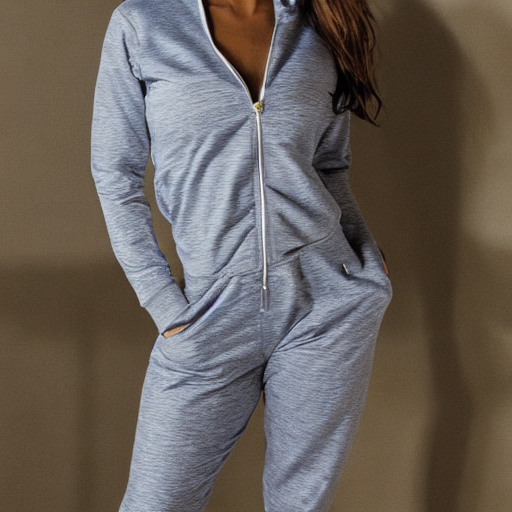

In [26]:
torch.manual_seed(1000)
prompt = "Sporty tracksuit"
pipe(prompt).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

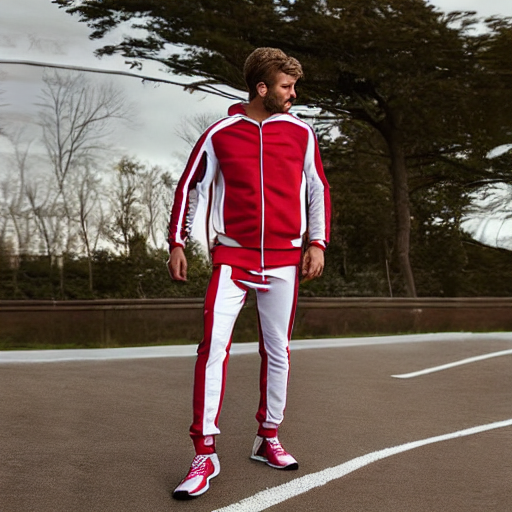

In [27]:
torch.manual_seed(1000)
pipe(prompt, negative_prompt="blue").images[0]

By using the negative prompt we move more towards the direction of the positive prompt, effectively reducing the importance of the negative prompt in our composition.

### Image to Image

Even though Stable Diffusion was trained to generate images, and optionally drive the generation using text conditioning, we can use the raw image diffusion process for other tasks.

For example, instead of starting from pure noise, we can start from an image an add a certain amount of noise to it. We are replacing the initial steps of the denoising and pretending our image is what the algorithm came up with. Then we continue the diffusion process from that state as usual.

This usually preserves the composition although details may change a lot. It's great for sketches!

These operations (provide an initial image, add some noise to it and run diffusion from there) can be automatically performed by a special image to image pipeline: `StableDiffusionImg2ImgPipeline`. This is the source code for its [`__call__` method](https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion_img2img.py#L124).

In [28]:
from diffusers import StableDiffusionImg2ImgPipeline
from fastdownload import FastDownload

In [29]:
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    revision="fp16",
    torch_dtype=torch.float16,
).to("cuda")

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

We'll use as an example the following sketch created by [user VigilanteRogue81](https://huggingface.co/spaces/huggingface-projects/diffuse-the-rest/discussions/204).

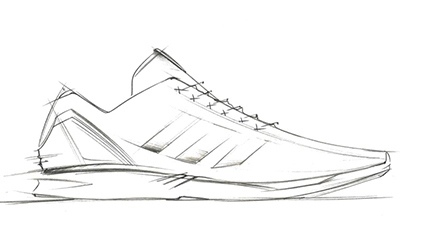

In [54]:
p = FastDownload().download('http://sneakernews.com/wp-content/uploads/2014/05/adidas-zx-flux-sam-handy-sketch.jpg')
init_image = Image.open(p).convert("RGB")
init_image

  0%|          | 0/100 [00:00<?, ?it/s]

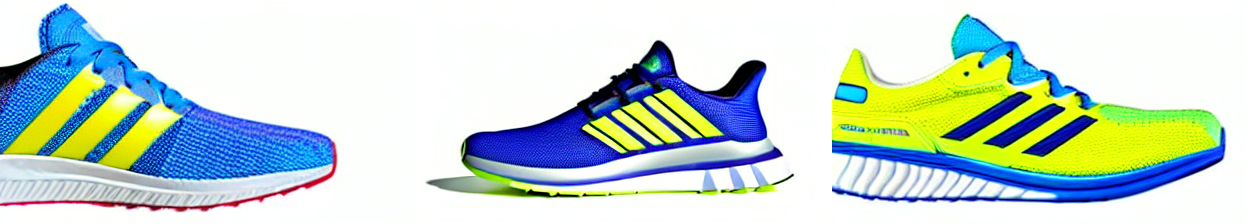

In [56]:
torch.manual_seed(1001)
prompt = "Adidas Running shoes on electric blue with yellow elements"
images = pipe(prompt=prompt, num_images_per_prompt=3, init_image=init_image, strength=1, num_inference_steps=100).images
image_grid(images, rows=1, cols=3)

When we get a composition we like we can use it as the next seed for another prompt and further change the results. For example, let's take the third image above and try to use it to generate something in the style of Van Gogh.

In [57]:
init_image = images[1]

  0%|          | 0/70 [00:00<?, ?it/s]

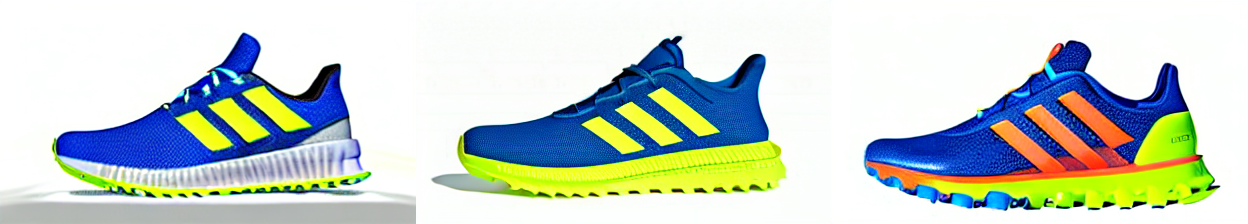

In [62]:
torch.manual_seed(1000)
prompt = "Trail running Adidas shoe with blue as main color with yellow design elements"
images = pipe(prompt=prompt, num_images_per_prompt=3, init_image=init_image, strength=1, num_inference_steps=70).images
image_grid(images, rows=1, cols=3)

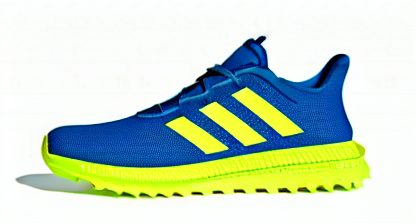

In [63]:
images[1]

Creative people use different tools in a process of iterative refinement to come up with the ideas they have in mind. Here's a [list with some suggestions](https://github.com/fastai/diffusion-nbs/blob/43a090286e5742f807d4ff58524c02a1888b3004/suggested_tools.md) to get started. 